In this document, following two problem will be addressed. <br/>
### Problems: -
1. How would you propose segmenting users in ways that can be useful for Sales, Product, and other teams?
2. Using that segmentation, how would you identify and predict high growth merchants  (merchants that we expect to significantly increase their transaction volume in the near future and become top users)? Please produce an actual prediction of high growth merchants.

----------
### Imports

Libraries used for solving the problem: - 
* Python 3
* scikit-learn, imblearn (for segmentation and prediction)
* matplotlib, mpl_toolkits, seaborn (for visualization)


In [3]:
import pandas as pd
import numpy as np

import dateutil
from datetime import datetime

#import visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mat
from mpl_toolkits.mplot3d import Axes3D

#import scikit-learn library 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.decomposition import PCA

from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier


### Read Data

Read data from csv file. 

In [4]:
#read data from file
raw_data = pd.read_csv('case_final (1).csv')

#Look at the data
print(raw_data.head())

#check for null or mission value
print("\n\nNull/Misisng Data :\n" , raw_data.isnull().sum())

print("\n\nTotal Transaction: ", len(raw_data))
print("Total Users:       ", len(set(raw_data.user)))


                                       user                      time  \
0  00038f0484334ac047449166cfbbf6452b31c85c  2016-02-19T23:39:56.925Z   
1  00038f0484334ac047449166cfbbf6452b31c85c  2016-02-19T23:41:47.026Z   
2  00038f0484334ac047449166cfbbf6452b31c85c  2016-02-23T15:19:54.836Z   
3  00038f0484334ac047449166cfbbf6452b31c85c  2016-02-23T15:21:08.273Z   
4  00038f0484334ac047449166cfbbf6452b31c85c  2016-02-24T15:19:39.386Z   

   amount_in_cents  
0             1203  
1             1203  
2             2405  
3             2405  
4             1203  


Null/Misisng Data :
 user               0
time               0
amount_in_cents    0
dtype: int64


Total Transaction:  1524710
Total Users:        8402


### Understanding the data

From initial observation, we see that there is total 1,524,710 transactions done by 8402 users/merchants.
Looking furthermore, there are only three fields: user, time and amount_in_cents. We only have the purchase history (when and how much did they spent). This data can be considered as the behavioral data as it gives the spending habit of the users.

### User Segmentation

One of the popular customer segmentation methods to analyze customer behavior is RFM analysis (usually used as a marketing model).

#### RFM Analysis 
***RFM*** stands for ***Recency***, ***Frequency***, and ***Monetary*** value (how recently, how often and how much did they buy). These RFM metrics are important indicators of a user’s behavior because the frequency and monetary value affects a user’s lifetime value, and recency affects retention, a measure of engagement.

RFM factors illustrate these facts:

1. ***Recency (R)*** : Who have purchased recently? Number of days since last purchase (least recency)
2. ***Frequency (F)*** : Who has purchased frequently? It means the total number of purchases. ( high frequency)
3. ***Monetary Value (M)*** : Who have high purchase amount? It means the total money customer spent (high monetary value)

Each of the three variables(Recency, Frequency, and Monetary) usually consist of four equal groups, which creates 64 (4x4x4) different customer segments. However, handling 64 segments is cumbersome, so we will reduce it to 7 important segments as follows: -

------------------

| Segements      | RFM | Description | Marketing Strategy|
| ------        | ----| ------------| ----------- |
| Best Customer | 111 | Bought most recently<br>most often<br>spend the most | No price incentives<br>new products<br>loyalty programs<br>Free marketing tools|
| New Customer  | 1xx | Buy one time &amp; haven't lost | Aggressive marketing|
| Loyal Customer| x1x | Bought most frequently | Build long term relationship|
| Big Spenders  | xx1 | Spend the most | Market your most expensive products|
| Almost Lost   | 211 | Haven’t purchased for some time, but purchased frequently and spend the most | Aggressive price incentives|
| Lost Customers| 311 | Haven’t purchased for some time, but purchased frequently and spend the most | Aggressive price incentives|
| Cheap Lost    | 3xx |Last purchased long ago, purchased few, and spent little | Never Mind|

------------------
### Data Preprocessing

As we are trying to segments the users based on ***RFM***, let us group the data by ***users*** and generate RFM metrics. 
* Recency: - Day since the last transaction 
* Frequency: - Total number of transcations since the beginning
* Monetary:- Sum of amount_in_cent for the user (total amount spent by the user)

### Steps of RFM(Recency, Frequency, Monetary): 
1. Calculate the Recency, Frequency, Monetary values for each customer. 
2. Add segment bin values to RFM table using manually defined threshold (usually quartiles).
3. Sort the customer RFM score in ascending order.

#### Step 1 Calculate the Recency, Frequency, Monetary values

In [5]:
#get transaction date
transaction = raw_data

transaction['time'] = pd.to_datetime(transaction['time'])
today = datetime.now()

#Get Days since Recent Transaction (recency), Frequency of transaction and Amount spent per Seller
transaction= transaction.groupby('user').agg({'time': lambda date: (today - date.max()).days, 'user':['count'], 'amount_in_cents': ['sum'] }).reset_index()
transaction.columns = ['user','recency','frequency','monetary']

print("Total Users: ", len(transaction))
print("\n\nData Description: \n", transaction.describe())

Total Users:  8402


Data Description: 
            recency     frequency      monetary
count  8402.000000   8402.000000  8.402000e+03
mean    833.825280    181.469888  2.177494e+06
std     174.755505   1768.910405  1.828659e+07
min     507.000000      1.000000  0.000000e+00
25%     698.000000      2.000000  1.611425e+04
50%     830.000000      9.000000  9.693000e+04
75%     958.000000     43.000000  6.119395e+05
max    1237.000000  85495.000000  9.650335e+08


#### Step 2 Add segment bin values to RFM table using quartile.

1. Function to calculate rank for each metrics
2. Function to define segment based on rfm value

In [6]:
# get rank for each metrics
def rank_r(x, p, t):
    if x <= t[p][0.25]:
        return str(1)
    elif x <= t[p][0.75]: 
        return str(2)
    else:
        return str(3)
    
def rank_f(x, p, t):
    if x <= t[p][0.75]:
        return str(3)
    else:
        return str(1)
    
def rank_m(x, p, t):
    if x <= t[p][0.25]:
        return str(3)
    elif x <= t[p][0.75]: 
        return str(2)
    else:
        return str(1)

def define_rfm_segment(rows):
    if rows['rfm_score'] == '111':
        return 'best_users'
    elif rows['rfm_score'] == '211':
        return 'almost_lost'
    elif rows['rfm_score'] == '311':
        return 'lost_users'
    elif rows['rank_r'] == '3':
        return 'cheap_lost'
    elif rows['rank_f'] == '1':
        return 'loyal_users'
    elif rows['rank_m'] == '1':
        return 'big_spender'
    elif rows['rank_f'] == '3':
        return 'new_customer'
    else:
        return rows['rfm_score']

#### Step 2 contd...

1. Calculate threshold for the segment bin
2. Get rank for each metric based on the threshold
3. Merge rank score to get rfm score
4. Finally, define segments based on rfm score
5. Print high-value customers (that bought recently, buys frequently and buy high-value items)

In [7]:
# Use 25 and 75th quantile to get rank for R, F and M ----
threshold = transaction.drop('user', axis=1).quantile(q=[0.25, 0.75])
threshold = threshold.to_dict()

transaction['rank_r'] = transaction['recency'].apply(rank_r, args=('recency', threshold))
transaction['rank_f'] = transaction['frequency'].apply(rank_f, args=('frequency', threshold))
transaction['rank_m'] = transaction['monetary'].apply(rank_m, args=('monetary', threshold))
transaction['rfm_score'] = transaction['rank_r'] + transaction['rank_f']+transaction['rank_m']

#Define segment based on RFM score 
transaction['segment'] = transaction.apply(define_rfm_segment, axis =1)

### Visualize the user segments

The following pie-charts shows the percentage of users in each segments.

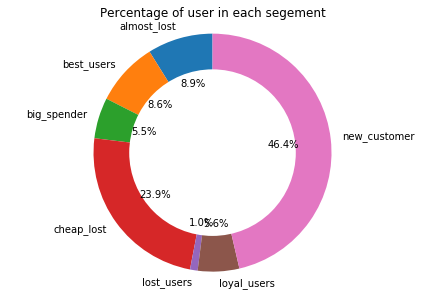

In [95]:
transaction_count = transaction.groupby('segment').agg({'user':['count'],'monetary':['sum']}).reset_index()
transaction_count.columns = ['segment','user','amount']
transaction_count[['amount']] = transaction_count[['amount']]/100
fig1, ax1 = plt.subplots()
ax1.pie(data=transaction_count, x='user', labels='segment',  autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Percentage of user in each segement")
plt.show()

### Visualize the user segments

The following pie-charts shows the percentage of the amount spent by each segments of the users. From above pie-chart we see that only 8.6% of the user belongs to best_customer category. However, they spend almost 48%.

One more point to notice, if we combine **almost lost** and **best customer** it accounts around 17% of the total users. And if we combine the amount spend by those two group it accounts for almost 88% of total transaction volume. This 17% user to 88% transaction volume is almost close to 80/20 rule (also known as the **Pareto Principle** :- 80% of the results generally come from 20% of the causes). In this context, it implies that ~80% of transcation volume would be produced by the top ~20% of customers. Also, In our case, this rule somewhat satisfies. Therefore, sales and marketing team should foucs their attention in retaining **almost lost** customer.

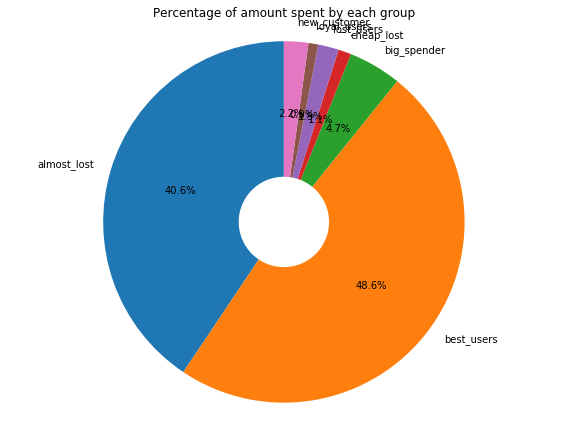

In [94]:
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(data=transaction_count, x='amount', labels='segment',  autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.25,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Percentage of amount spent by each group")
plt.show()

### Visualizing scatter plot

The scatter plot shows the user segment. As we see in the scatter plot, the red cluster has the least recency, high monetary and also high frequency to blue and yellow cluster so it refer the best user segments.

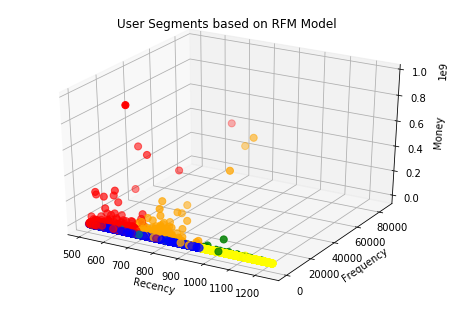

In [9]:
segment = {'best_users':0, 'lost_users':1, 'new_customer':2, 'loyal_users':3, 'cheap_lost':4, 'big_spender':5, 'almost_lost':6}
label = [segment[item]for item in transaction['segment']]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax = Axes3D(fig)
colors = ['red','green','blue','purple', 'yellow','teal','orange']
ax.scatter(transaction['recency'], transaction['frequency'],  transaction['monetary'], c=label, s=50, cmap=mat.colors.ListedColormap(colors))
ax.set_xlabel('Recency',  rotation=150)
ax.set_ylabel('Frequency')
ax.set_zlabel('Money', rotation=60)
plt.title('User Segments based on RFM Model')
plt.show()

### Users Segments and their usefulness to the business departments

Each of the above segments is useful for various department of the company. Following table summarizes how each segment can be useful.

------------------

'#'| Segment       | Department | Usefulness|
---| ------         | ------------| ----------- |
1. | Best Customer  | Sales/Product | Make new product and sale it to them|
2. | New Customer   | Marketing | Try to introduce the loyalty program. Make sure their initial experience with your product and service is pleasant and memorable so they buy again. Sending educational content.|
3. | Loyal Customer | Product | Can contact loyal customers even before building a product. They can provide you great insights into what to build and how to promote it. This group of people will also happily refer the product to their circles of influence.|
4. | Big Spenders   | Marketing | Market your most expensive products|
5. | Almost Lost    | Sales/Marketing | Send personalized emails or call to reconnect with these customers. Offer purchases at a discount or run surveys to address their concerns.|
6. | Lost Customers | Sales/Marketing | Aggressive price incentives to retain them|
7. | Cheap Lost     | --- |You can ignore them|

------------------


### Who are high growth merchant (user)?

Based on the above segmentation, segment 1 (**Best Customer**) buy recently, buy frequently and spends lots of money. So, they have the potential to be high growth merchant. Also, based on the definition of high growth merchant in problem no. 2,(*merchants that we expect to significantly increase their transaction volume*) segment 4 (**Big Spenders**) can also be considered high growth merchant because even though they buy less frequently but their transaction have monetary value resulting in higher sales volume.

Therefore, we can assume **Best valued users** and **Big Spenders** as **High Growth Users** because they are the one that bought most recently, buy most often and spend a lot of money.

Now by labeling users belonging to these 2 segments as "high growth customer" and other as "low growth customer", we can make a labeled dataset for a supervised machine learning model to predict high growing merchant for future.

In [10]:
#function to label each user as high growth or not
def Label_Segments(rows):
    if rows['segment'] == 'best_users':
        return 1
    elif rows['segment'] == 'big_spender':
        return 1
    else:
        return 0

transaction['high_growth'] = transaction.apply(Label_Segments, axis =1)
user_label = transaction[['user', 'high_growth']]

### High Growth Users 

Let's check how many users have high growth?
Here, you can plot a pie chart using Matplotlib. Around 14% of the user is high growth users.

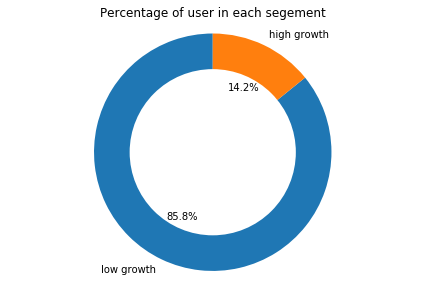

In [124]:
growth_count=transaction.groupby('high_growth').agg({'user':['count'],'monetary':['sum']}).reset_index()
growth_count.columns = ['segment','user','amount']
growth_count.loc[growth_count['segment']==0, 'segment'] ='low growth'
growth_count.loc[growth_count['segment']==1, 'segment'] ='high growth'

fig1, ax1 = plt.subplots()
ax1.pie(data=growth_count, x='user', labels='segment',  autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Percentage of user in each segement")
plt.show()

### Amount Spent by High Growth Users 
Though, there are only 14.1 high growth user, they account for around 53% of the total transaction volume.

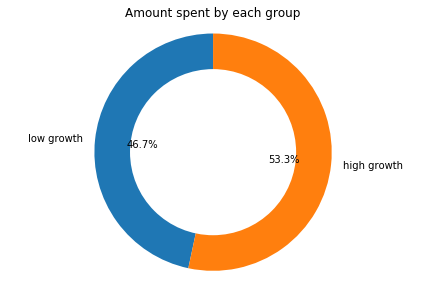

In [125]:
fig1, ax1 = plt.subplots()
ax1.pie(data=growth_count, x='amount', labels='segment',  autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Amount spent by each group")
plt.show()

 ### Feature Generation for Prediction
 
For predicting users that are potentially high growth users using supervised machine learning model, let us generate some features.

<br/>
$1.$ First we divide time into Year and Month <br/>
$2.$ We will generate recency, frequency (total transaction), and monetary (total amt in cent) as before. Also, we will generate mean amount and max amount per year.<br/>
$3.$ We will find how long the user has been the customer and use it as a feature called *cust_dur*.<br/>
$4.$ There might be some seasonal behavior. Therefore, we will calculate the count and amt per month and merge them into 4 seasons.<br/>
$5.$ As we are looking to predict high growth merchant, we would like to see the difference in amount spent by the merchant in their first year in comparison to the recent year. This might give us an indication of how the merchant is spending (either spending more or less). 


#### Step 1, 2, 3

In [128]:
user_data = raw_data

#convert time in datetime
user_data['time'] = pd.to_datetime(user_data['time'])

#convert amount into dollar
user_data['amount_in_cents'] = user_data['amount_in_cents']
today = datetime.now()
user_data['year'] = raw_data['time'].apply(lambda x: x.year)
user_data['month'] = raw_data['time'].apply(lambda x: x.month)
user_data['day_since'] = raw_data['time'].apply(lambda x: (today-x).days)
user_data = raw_data[['user','time','amount_in_cents', 'year', 'month', 'day_since']]
dataset_year = raw_data.groupby('user')['year','amount_in_cents'].agg({'year':['min','max'], 'amount_in_cents':['sum','mean','count','max'],'day_since':['max'], 'time': lambda date: (today - date.max()).days}).reset_index()
dataset_year.columns = ['user', 'since', 'till', 'monetary', 'mean', 'frequency','max','cust_dur','recency']

print("Total User: ", len(dataset_year))
#print(dataset_year.head())

Total User:  8402


#### Step 4:- Get transaction count and amout per month. and merge them into 4 season

In [129]:
#get transaction count per month
dataset_mcount = user_data.groupby(['user','month']).size().reset_index()
dataset_mcount.columns = ['user', 'month','count']
dataset_mcount = dataset_mcount.pivot(index = 'user', columns='month', values='count')
dataset_mcount.columns = ['m{:d}c'.format(col) for col in dataset_mcount.columns]
dataset_mcount = dataset_mcount.reset_index()

#get transaction Amt per month
dataset_mamt = user_data.groupby(['user','month']).agg({'amount_in_cents':['sum']}).reset_index()
dataset_mamt.columns = ['user', 'month','amt']
dataset_mamt = dataset_mamt.pivot(index = 'user', columns='month', values='amt')
dataset_mamt.columns = ['m{:d}a'.format(col) for col in dataset_mamt.columns]
dataset_mamt = dataset_mamt.reset_index()

#Merge all into one data frame 
header =  ['user', 'since', 'till', 'cust_dur', 'monetary', 'mean', 'frequency', 'max', 'recency','m1c', 'm2c', 'm3c',
         'm4c', 'm5c', 'm6c','m7c', 'm8c', 'm9c','m10c', 'm11c', 'm12c', 'm1a', 'm2a', 'm3a',
         'm4a', 'm5a', 'm6a','m7a', 'm8a', 'm9a','m10a', 'm11a', 'm12a']

final_dataset = pd.DataFrame(index=range(0, len(dataset_year)), columns = header)
final_dataset = final_dataset.fillna(dataset_year)
final_dataset = final_dataset.fillna(dataset_mcount)
final_dataset = final_dataset.fillna(dataset_mamt)
final_dataset = final_dataset.fillna(0)


#Now combine months data to season
#Get seasonal count
final_dataset['spring_count'] = final_dataset['m1c']+final_dataset['m2c']+final_dataset['m3c']
final_dataset['summer_count'] = final_dataset['m4c']+final_dataset['m5c']+final_dataset['m6c']
final_dataset['fall_count'] = final_dataset['m7c']+final_dataset['m8c']+final_dataset['m9c']
final_dataset['winter_count'] = final_dataset['m10c']+final_dataset['m11c']+final_dataset['m12c']

final_dataset['spring_amt'] = final_dataset['m1a']+final_dataset['m2a']+final_dataset['m3a']
final_dataset['summer_amt'] = final_dataset['m4a']+final_dataset['m5a']+final_dataset['m6a']
final_dataset['fall_amt'] = final_dataset['m7a']+final_dataset['m8a']+final_dataset['m9a']
final_dataset['winter_amt'] = final_dataset['m10a']+final_dataset['m11a']+final_dataset['m12a']

final_dataset = final_dataset[['user', 'cust_dur', 'monetary', 'mean', 'frequency', 'max','recency','spring_count', 'summer_count', 'fall_count','winter_count','spring_amt','summer_amt','fall_amt','winter_amt']]


print("Total User: ", len(final_dataset))
#print(final_dataset.head())

Total User:  8402


#### Step 5:

In [130]:
user_year = user_data.groupby(['user', 'year'])['amount_in_cents'].sum().reset_index()
user_year.columns = ['user','year','amount']
#print(user_year.head(20))

user_year['sales_growth'] = user_year['amount'].diff() #(user_year['amount'].diff()/user_year['amount'].shift(1))*100
user_year.loc[user_year.user != user_year.user.shift(1), 'sales_growth'] = 0
user_year = user_year.groupby(['user'])['sales_growth'].sum().reset_index()

#print(user_year.head(20))
#merge sales growth in the final dataset
final_dataset = final_dataset.merge(user_year)
print("Total User: ", len(final_dataset))
#print(final_dataset.head())

Total User:  8402


### Use RFM Cluster Label for High Growth Merchant

In [131]:
#print(user_label)
final_dataset = final_dataset.merge(user_label)
#print(final_dataset.head())

### Final Dataset

In [132]:
final_dataset.describe()

,cust_dur,monetary,mean,frequency,max,recency,spring_count,summer_count,fall_count,winter_count,spring_amt,summer_amt,fall_amt,winter_amt,sales_growth,high_growth
count,8402.000000,8.402000e+03,8.402000e+03,8402.000000,8.402000e+03,8402.000000,8402.000000,8402.000000,8402.00000,8402.000000,8.402000e+03,8.402000e+03,8.402000e+03,8.402000e+03,8.402000e+03,8402.000000
mean,989.396334,2.177494e+06,2.438892e+04,181.469888,8.945987e+04,833.843133,43.778981,40.831588,42.37253,54.486789,5.382620e+05,5.306773e+05,5.348953e+05,5.736591e+05,1.193076e+05,0.141871
std,132.107616,1.828659e+07,6.924446e+04,1768.910405,2.831950e+05,174.759228,439.866339,415.139551,448.77581,622.107673,5.390773e+06,4.857679e+06,4.635589e+06,4.872156e+06,9.629321e+06,0.348939
min,523.000000,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,507.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.512821e+08,0.000000
25%,898.000000,1.611425e+04,3.525133e+03,2.000000,6.013000e+03,698.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,990.000000,9.693000e+04,7.431215e+03,9.000000,1.966250e+04,831.000000,1.000000,1.000000,1.00000,1.000000,4.810000e+03,5.532000e+03,6.133000e+03,7.456000e+03,0.000000e+00,0.000000
75%,1091.000000,6.119395e+05,2.032342e+04,43.000000,6.115200e+04,958.000000,8.000000,8.000000,8.00000,9.000000,9.485475e+04,1.006572e+05,1.001478e+05,1.177040e+05,0.000000e+00,0.000000
max,1237.000000,9.650335e+08,2.281332e+06,85495.000000,9.949711e+06,1237.000000,23896.000000,17013.000000,21502.00000,26903.000000,3.235230e+08,1.979841e+08,1.960534e+08,2.474730e+08,4.635650e+08,1.000000


### Predicting High Growth Merchant


Here, we are going to predict **High Growth Merchant** using Logistic Regression. To understand the model performance, dividing the dataset into a training set and a test set is a good strategy. The dataset is broken into two parts in the ratio of 70:30. It means 70% of the data will be used for model training and 30% for model testing.

Starting with the above-generated sets of feature let's see how logistic regression would perform for predicting high growth merchants.
Here we will do the following:- 

1. We scale (normalize) the data
2. We split data into train and test set (70-30%) 
3. We use logistic regression and check training and test accuracy 

In [133]:
#Function to print result of the classifier
def print_result(y_test, y_pred):
    target_names = ['Low Growth', 'High Growth']
    print(metrics.classification_report(y_test, y_pred, target_names=target_names))
    print("Confusion Matrix: \n", metrics.confusion_matrix(y_test, y_pred))
    
X = final_dataset.drop(columns=['user','high_growth'])
X = preprocessing.scale(X)
y = final_dataset['high_growth']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training and 30% test
    
print("\n\nLogistic Regression...")
log = linear_model.LogisticRegression(solver = 'liblinear')
log.fit(X_train, y_train)

#check if the model is correct in train data
print("\n\nTraining")
y_pred = log.predict(X_train)
print_result(y_train, y_pred)

print("\n\nTesting")
#now predict on test data
y_pred = log.predict(X_test)
print_result(y_test, y_pred)



Logistic Regression...


Training
              precision    recall  f1-score   support

  Low Growth       0.92      0.97      0.95      5064
 High Growth       0.74      0.48      0.58       817

   micro avg       0.90      0.90      0.90      5881
   macro avg       0.83      0.73      0.76      5881
weighted avg       0.90      0.90      0.90      5881

Confusion Matrix: 
 [[4926  138]
 [ 426  391]]


Testing
              precision    recall  f1-score   support

  Low Growth       0.91      0.97      0.94      2146
 High Growth       0.75      0.48      0.58       375

   micro avg       0.90      0.90      0.90      2521
   macro avg       0.83      0.72      0.76      2521
weighted avg       0.89      0.90      0.89      2521

Confusion Matrix: 
 [[2086   60]
 [ 196  179]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


From above, we see that our model have decent performance predicting low growth merchant. However, for high growth merchant, the performance is low.

So, to make sure that we are not overfitting the model and are using essential/good features, let us do some feature selection.

### Feature Selection 
***Feature Selection*** is the process of selecting the attributes that can make the predicted variable more accurate or eliminating those attributes that are irrelevant and can decrease the model accuracy and quality. 

Data and feature correlation is considered one of the important step in the feature selection phase of the data pre-processing especially if the data type for the features is continuous. 

***Data Correlation*** helps to understand the relationship between multiple variables and attributes in the dataset. Using Correlation, you can get some insights such as:

1. One or multiple attributes depend on another attribute or a cause for another attribute.
2. One or multiple attributes are associated with other attributes.

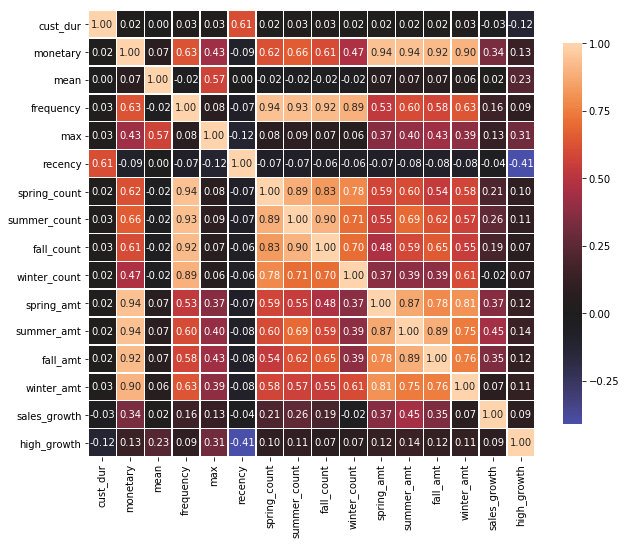

In [134]:
def correlation_heatmap(final_dataset):
    correlations = final_dataset.corr()
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();

correlation_heatmap(final_dataset)

As we can see in the above matrix, there is a high correlation between monetary -> seasonal amt and frequency -> seasonal count. It is understandable as we generate these seasonal features by breaking down the monetary and frequency. Also, the correlation is between frequency -> monetary and mean -> max. So, we will remove one feature from each correlation set that have correlation value of more than 65%.

Also, another striking fact is that recency has a negative correlation with high_growth. We can see that higher the value of recently then a chance of high growth is low (i.e these users are lost or about to be lost)

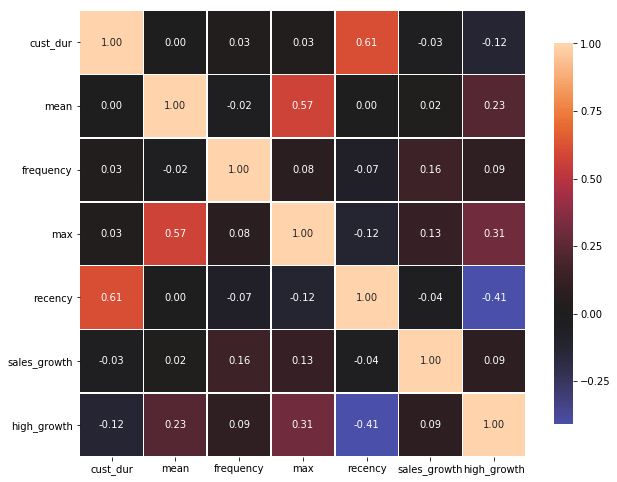

In [135]:
selected_feature = final_dataset.drop(columns=['monetary','fall_count','spring_count','summer_count','winter_count','spring_amt','summer_amt','winter_amt','fall_amt'])
correlation_heatmap(selected_feature)

### Prediction Model 

Now, using the remaining features let's do prediction using Logistic Regression again.

In [136]:
X = selected_feature.drop(columns =['user','high_growth'])
y = selected_feature['high_growth']
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training and 30% test
 
print("\n\nLogistic Regression...")
log = linear_model.LogisticRegression(solver = 'liblinear')
log.fit(X_train, y_train)

#check if the model is correct in train data
print("Training\n\n")
y_pred = log.predict(X_train)
print_result(y_train, y_pred)

print("Testing\n\n")
#now predict on test data
y_pred = log.predict(X_test)
print_result(y_test, y_pred)



Logistic Regression...
Training


              precision    recall  f1-score   support

  Low Growth       0.92      0.97      0.95      5064
 High Growth       0.74      0.47      0.57       817

   micro avg       0.90      0.90      0.90      5881
   macro avg       0.83      0.72      0.76      5881
weighted avg       0.89      0.90      0.89      5881

Confusion Matrix: 
 [[4928  136]
 [ 434  383]]
Testing


              precision    recall  f1-score   support

  Low Growth       0.91      0.97      0.94      2146
 High Growth       0.74      0.48      0.58       375

   micro avg       0.90      0.90      0.90      2521
   macro avg       0.83      0.72      0.76      2521
weighted avg       0.89      0.90      0.89      2521

Confusion Matrix: 
 [[2083   63]
 [ 196  179]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


By reducing feature set, there was little/no effect in the model performance. Therefore, we can ignore all those seasonal features for good.

### Using Cross-Validation

To make sure our model is not overfitted, let us try 10-fold cross-validation.

In [137]:
X = selected_feature.drop(columns =['user','high_growth'])
y = selected_feature['high_growth']
X = preprocessing.scale(X)

log = linear_model.LogisticRegression(solver = 'liblinear')
y_pred = cross_val_predict(log, X, y, cv=10)
print("\n\nLogistic Regression...\n\n")
print_result(y,y_pred)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until




Logistic Regression...


              precision    recall  f1-score   support

  Low Growth       0.92      0.97      0.94      7210
 High Growth       0.74      0.47      0.57      1192

   micro avg       0.90      0.90      0.90      8402
   macro avg       0.83      0.72      0.76      8402
weighted avg       0.89      0.90      0.89      8402

Confusion Matrix: 
 [[7011  199]
 [ 637  555]]


Again, using 10-fold cross validation, there was little/no effect in the model performance. 

###  Imbalance Nature of the Data

After feature selection and using cross-validation also, our prediction performance for **High Growth Merchant** did not improve significantly. One potential reason for this is the imbalance nature of the data (High growth to low growth ratio is ~3:20).

In supervised learning, a common strategy to overcome the class imbalance problem is to resample the original training dataset to decrease the overall level of class imbalance. Resampling is done either by oversampling the minority (positive) class and/or under-sampling the majority (negative) class until the classes are approximately equally represented.

Before going to different re-sampling techniques one most important thing to keep in mind is that all resampling operations have to be applied to only training datasets. If upsampling is done before splitting the dataset into a train and validation set, then it could end up with the same observation in both datasets. As a result, a machine learning model will be able to perfectly predict the value for those observations when predicting on the validation set, hence inflating the accuracy and recall.

Even though undersampling and oversampling approaches address the class imbalance problem, they also suffer some drawbacks. The random undersampling method can potentially remove certain important data points, and random oversampling can lead to overfitting. SMOTE can avoid this pitfall.


**SMOTE: Synthetic Minority Over-sampling Technique** <br/> 
SMOTE has been designed to generate new samples that are coherent with the minor class distribution. The main idea is to consider the relationships that exist between samples and create new synthetic points along the segments connecting a group of neighbors. We will oversample minority class (high growth merchant) using SMOTE technique.

In [138]:
sm = SMOTE(random_state=12)

X = selected_feature.drop(columns=['user','high_growth'])
y = final_dataset['high_growth']

X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training and 30% test

#oversample the training set
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
x_test_res, y_test_res = sm.fit_sample(X_test, y_test)
print (y_train.value_counts())
print("New Data", np.bincount(y_train_res))

print("\n\nLogistic Regression...")
log = linear_model.LogisticRegression(solver='liblinear')
log.fit(x_train_res, y_train_res)

#check if the model is correct in train data
print("\n\nTraining")
y_pred = log.predict(x_train_res)
print_result(y_train_res, y_pred)
print("\n\nTesting")
#now predict on test data
y_pred = log.predict(X_test)
print_result(y_test, y_pred)

0    5064
1     817
Name: high_growth, dtype: int64
New Data [5064 5064]


Logistic Regression...


Training
              precision    recall  f1-score   support

  Low Growth       0.90      0.83      0.86      5064
 High Growth       0.84      0.90      0.87      5064

   micro avg       0.87      0.87      0.87     10128
   macro avg       0.87      0.87      0.87     10128
weighted avg       0.87      0.87      0.87     10128

Confusion Matrix: 
 [[4190  874]
 [ 482 4582]]


Testing
              precision    recall  f1-score   support

  Low Growth       0.97      0.84      0.90      2146
 High Growth       0.49      0.87      0.63       375

   micro avg       0.85      0.85      0.85      2521
   macro avg       0.73      0.86      0.77      2521
weighted avg       0.90      0.85      0.86      2521

Confusion Matrix: 
 [[1806  340]
 [  48  327]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


Using SMOTE in training data, the recall for minority class (High Growth) for the test case is increase up to 87% from 46% and Also the F1-Score improved to 63% from 51%.

Now, let us try several other algorithms and see their performance. We will use the following three algorithm with 10-fold cross validation.
1. Decision Tree
2. Random Forest
3. SVM

In [139]:
X = selected_feature.drop(columns=['user','high_growth'])
y = final_dataset['high_growth']
#X = preprocessing.scale(X)

decision_tree_classifier = DecisionTreeClassifier()
y_pred = cross_val_predict(decision_tree_classifier, X, y, cv=10)
print("\n\nDecision Tree...")
print_result(y,y_pred)
    
random_forest_classifier = RandomForestClassifier(n_estimators=10, criterion="entropy")
y_pred_rf = cross_val_predict(random_forest_classifier, X, y, cv=10)
print("\n\nRandom Forest...")
print_result(y, y_pred_rf)    

svm_classifier = svm.SVC(kernel="linear")
y_pred = cross_val_predict(svm_classifier, X, y, cv=10)
print("\n\nSVM ...")
print_result(y,y_pred) 



Decision Tree...
              precision    recall  f1-score   support

  Low Growth       0.99      0.99      0.99      7210
 High Growth       0.93      0.92      0.93      1192

   micro avg       0.98      0.98      0.98      8402
   macro avg       0.96      0.96      0.96      8402
weighted avg       0.98      0.98      0.98      8402

Confusion Matrix: 
 [[7126   84]
 [  91 1101]]


Random Forest...
              precision    recall  f1-score   support

  Low Growth       0.99      0.99      0.99      7210
 High Growth       0.96      0.92      0.94      1192

   micro avg       0.98      0.98      0.98      8402
   macro avg       0.97      0.96      0.96      8402
weighted avg       0.98      0.98      0.98      8402

Confusion Matrix: 
 [[7167   43]
 [  99 1093]]


### Prediction Results

Here, we have summerized the results of classification algorithms for predicting high growth merchants.

------------------

Algorithm | Precision  | Recall | F1-Score|
----------| ------         | ------------| ----------- |
Logistic Regression  (using SMOTE)| 0.90 |   0.85 | 0.86   |
Decision Tree |  .98 | 0.98  |  0.98 |
Random Forest |  **0.99**  | **0.99**   |   **0.99**  |
SVM    |   0.88 | 0.89    |  0.87   |      |

-----------------

Random Forest gave the best performance, understandbly so given that random forest is ensemble technique.

### List of High Growth Merchants

Since Random Forest gave the best recall and precision, the list of high growth merchant predicted by random forest is given below:-

The list is saved in CSV file name "high_growth_merchant.csv" and is attached in the submission folder.



In [140]:
final_dataset['predicted'] = y_pred_rf
high_growth_merchant = final_dataset[['user', 'monetary']].loc[final_dataset['predicted']==True]

high_growth_merchant[['user', 'monetary']].sort_values('monetary', ascending=False).to_csv('high_growth_merchant.csv',index=False)

print("High Growth Merchant: \n",high_growth_merchant[['user', 'monetary']].sort_values('monetary', ascending=False))


High Growth Merchant: 
                                           user   monetary
77    027f215d6ff7750f5a07a68bf5c6501b4612dc82  965033487
2662  5068906d0a6c0e88bac8866f9cced904571171db  438639329
2291  44e472d7492b2f8588f81fb25faf12bb12158ff9  430745594
3270  64b432cc4704f6645eff28417c6eeecc4213947a  383266633
1377  298698d8952c600c404b1bf8df7eabc9937940aa  267813773
5589  ad5e84765e7c83aef722278c504fbe1a75299801  264147257
5673  afcd09fd9ec6a537fa1b5e4ac104aae2d35258c3  238051392
439   0d7f46affc003fa8c8caa44407710510d0952b77  220829148
1037  1f9728eedff7af82c9dff4c993b72350ca13878b  218338356
3933  796fc77904aea3dc2d1b391b7a6d1204143dc800  208497257
2208  427dc795aeda1aeda416a2e7c95d7268ce9e3e31  172372474
2128  3fdacc075e6a0c707c78d342a1c552a0fd20c6b0  153424839
5199  a0cedd4229e30b73f7c9f4337b7581b6a3c3d584  115889680
4652  8fb8ac732b3121d3799b007b0e1ab7fc35ead1f1  101848875
2330  4603247c2e55b103965bc18c5a941c130f58b495   97327047
1199  247e106f37a4d581c2aa9ee05e662723c92f534e  

### Future Works

1. I would investigate the clustering approach like K-Mean to see if we can get a similar segment for high growth merchants.
2. Try to run a few other classification algorithms like neural network and see how they perform.
3. I would tune parameters for each algorithm using grid search. 